In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import networkx as nx
import random
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from umap.umap_ import UMAP


/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# User data
 
I'm trying out different approches here: 
 - Visualising the books using the titles and applying LDA for topic extraction
 - Visualising the books using the titles and user data as metric
 - Visualising the users using common books as metric
 - Using networkx to create a network of books
 

In [24]:

user_df = pd.DataFrame()

csv_directory = 'user_data'

for filename in os.listdir(csv_directory):
    if filename.endswith(".csv"):
        year = filename.split('.')[0]
        print(year)
        file_path = os.path.join(csv_directory, filename)
        df = pd.read_csv(file_path, delimiter=';')
        df['Year'] = year  # Add a 'Year' column with the year value
        user_df = pd.concat([user_df, df], ignore_index=True)



2020
2021
2023
2022
2019
2018
2015


ParserError: Error tokenizing data. C error: Expected 11 fields in line 66877, saw 12


In [25]:
user_df

,Z30_CALL_NO,Z30_COLLECTION,Z30_BARCODE,Z30_INVENTORY_NUMBER,Z30_DESCRIPTION,Z30_NO_LOANS,Z36H_LOAN_DATE,Z36H_RETURNED_DATE,Z36H_ID,Z36H_LOAN_CATALOGER_NAME,"Z13_TITLE,,,,,",Year,"Z13_TITLE,,,,,,","Z13_TITLE,,,,,,,,","Z13_TITLE,,,,,,,,,"
0,Ha 280-6080,BIB,E004010041AD2DFD,2014.1366,NaN,10,20200826,20200902,BHR-1048,SELFCHECK,"Die Sprache der Materialien,,,,,",2020,NaN,NaN,NaN
1,Va 6400-6090,MAG,E0040100413A8184,2009.4815,NaN,64,20201022,20201105,MPG000012838,SELFCHECK,"The Accademia seminars,,,,,",2020,NaN,NaN,NaN
2,KatM-AVI 5720-5760/a,BIB,E004010042EB1ED0,1990.2315,NaN,3,20200924,20201006,BHR-575,SELFCHECK,"Avignon, MusÈe du Petit Palais,,,,",2020,NaN,NaN,NaN
3,Hm 9000-6110/1,BIB,E004010043854685,2011.2460,NaN,6,20200908,20200910,BHR-1062,SELFCHECK,"Handbuch der politischen Ikonographie,,,,,",2020,NaN,NaN,NaN
4,Cm-PON 7500-6112/1,BIB,E004010042EB5DA0,2012.645,NaN,1,20200609,20220228,BHR-980,SELFCHECK,"Espressioni di Gio Ponti,,,,,",2020,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121430,Per B 660-5810,ZS,E0040100413669FC,NaN,9.1989(1990)=Nr.17-18,1,20180907,20180907,BHR-407,SELFCHECK,NaN,2018,NaN,NaN,Rassegna del Centro di Cultura e Storia Amalfi...
121431,Zk 1004-6142;MAG ;E00401080A72C252 ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,NaN,NaN,NaN
121432,De 790-6180,BIB,E00401080A736024,2018.4700,NaN,1,20180831,20180905,MPG000012277,KUBA4R01,NaN,2018,NaN,NaN,"J¸disches Rom,,,,,,,,,"
121433,Bb 780-6180 gr,BIB,E00401080A72DBD4,2018.6473,NaN,1,20181121,20190730,MPG000012293,KUBA4R01,NaN,2018,NaN,NaN,"Italy around 1900,,,,,,,,,"


In [12]:
user_path = 'user_data/2012.csv'
user_data = pd.read_csv(user_path, encoding='ISO-8859-1',delimiter=';')
user_data = user_data.drop_duplicates()

freihand_path = 'data/hertziana_exp/freihand_signatures.csv'
freihand = pd.read_csv(freihand_path)


In [3]:
subject_dict= {'A': 'Manuals', 'B': 'Italian Art', 'C': 'Italian Artists', 'D': 'Rome','E':'Italian Topography', 'F': 'Travel Literature', 
               'G': 'Sources', 'H': 'Iconography', 'J': 'Ornament','K': 'Kat and K', 'L': 'Congress Publications', 'M': 'Art in General',
                'N': 'Architecture', 'O':'Sculpture', 'P': 'Painting', 'Q': 'Manuscript Illumination', 'R': 'Graphic Arts', 
               'S': 'Applied Arts', 'T': 'Collecting Art, Museum Studies', 'U': 'Registers of Artistic Monuments', 'V': 'Cultural Institutions', 
               'W': 'Non-Italian Artists','X': 'European Topography', 'Y': 'World Topography', 'Z': 'Related Disciplines', ' ': 'None'}


custom_colours = ["#EA522B", "#EFD4D1", "#2A4978", "#8BDBE1", "#ECA19D", "#B48E36", "#E1DCE0", "#B8BFCE", "#E0DCD1", "#91C5E4", 
                  "#6E8EAC", "#D2E7E0", "#ECD096", "#6C9686", "#E6E10F", "#9D4B37", "#A3B49D", "#BDC920", "#DBE3E5", "#6A8B8D", "#EFB3D1"]
custom_cmap = ListedColormap(custom_colours)

In [4]:
print('Users in dataset: {}'.format(user_data.Z36H_ID.unique().size))
print('Unique books in dataset: {}'.format(user_data.Z30_CALL_NO.unique().size))
book_counts = user_data.groupby('Z30_CALL_NO')['Z36H_ID'].count()
book_counts.nlargest(5)

Users in dataset: 271
Unique books in dataset: 30163


Z30_CALL_NO
Per B 100-5071      403
Per B 100-5504/a    292
Per K 210-5030      285
Per B 100-5690      245
Per B 100-5756      161
Name: Z36H_ID, dtype: int64

In [9]:
#Join with Freihand dataset to get more info 
merged_df = user_data.merge(freihand, left_on='Z30_CALL_NO', right_on='signature', how='inner')

print(merged_df.groupby('lang')['bvb'].count().sort_values(ascending=False))

#dataframes for top 4 langs
eng = merged_df[merged_df.lang == 'eng']
ita = merged_df[merged_df.lang == 'ita']
ger = merged_df[merged_df.lang == 'ger']
fre = merged_df[merged_df.lang == 'fre']

lang
ita    26444
eng     5072
ger     3694
fre     1459
und      612
lat      257
spa      192
dut       49
rum       18
gre       14
pol       12
cat       11
rus        9
por        9
jpn        8
cze        6
dan        4
srp        4
swe        4
slv        3
mul        2
hrv        2
nor        1
hun        1
grc        1
ara        1
Name: bvb, dtype: int64


In [10]:
eng.columns

Index(['Z30_CALL_NO', 'Z30_COLLECTION', 'Z30_BARCODE', 'Z30_INVENTORY_NUMBER',
       'Z30_DESCRIPTION', 'Z30_NO_LOANS', 'Z36H_LOAN_DATE',
       'Z36H_RETURNED_DATE', 'Z36H_ID', 'Z36H_LOAN_CATALOGER_NAME',
       'Z13_TITLE', 'bvb', 'title', 'signature', 'inventory_nr',
       'inventory_date', 'inventory_year', 'lang', 'year', 'sys', 'text',
       'text_1', 'text_2', 'text_3', 'sig_lev_1', 'sig_lev_2'],
      dtype='object')

In [11]:
eng

,Z30_CALL_NO,Z30_COLLECTION,Z30_BARCODE,Z30_INVENTORY_NUMBER,Z30_DESCRIPTION,Z30_NO_LOANS,Z36H_LOAN_DATE,Z36H_RETURNED_DATE,Z36H_ID,Z36H_LOAN_CATALOGER_NAME,...,inventory_year,lang,year,sys,text,text_1,text_2,text_3,sig_lev_1,sig_lev_2
5,De 60-6110,BIB,E0040100437711DE,2011.2497,NaN,4,20141027,20141027,MPG000012923,SELFCHECK,...,2011.0,eng,2011.0,De 60,Inschriftensammlungen,Topographie_Rom,Geschichte_und_Kulturgeschichte,NaN,D,De
33,Hd 573-6110,BIB,E0040100438530D3,2012.1581,NaN,8,20140212,20141027,MPG000013093,SELFCHECK,...,2012.0,eng,2011.0,Hd 573,"Neuzeit_(nach_1500),_Italien",Ikonographie,Mythologischer_Themenkreis,Ikonographie_im_Themenbereich_der_griechisch-r...,H,Hd
39,Tm 1135-6120,BIB,E004010043762B20,2012.3143,NaN,3,20140620,20140620,MPG000012870,SELFCHECK,...,2012.0,eng,2012.0,Tm 1135,westeuropäische_Länder,Kunstsammeln_und_Kunstpflege_(ohne_Italien_spe...,"Museums-,_Austellungs-und_Restaurierungswesen",Restaurierungswesen,T,Tm
74,Mb 705-6124,BIB,E004010042E9B8EB,2012.1937,NaN,15,20140207,20140207,MPG000012926,SELFCHECK,...,2012.0,eng,2012.0,Mb 705,Kunst_und_Religion,Kunst_allgemein_(ohne_Italien_speziell),Theoretische_Grundlagen_und_Randgebiete_der_Ku...,Motivgeschichtliche_Monographien,M,Mb
80,Bt 2028-6110,BIB,E004010042E98B25,2012.1313,NaN,10,20140912,20140912,MPG000012881,SELFCHECK,...,2012.0,eng,2011.0,Bt 2028,Wesen_und_Praxis_der_Denkmalpflege,Italienische_Kunst,Kunstsammeln_und_Kunstpflege,"Denkmalpflege,_Kunstschutz_im_Kriege,_Kunstraub",B,Bt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62266,Bb 520-6141,BIB,E004010041AEF52C,2014.3961,NaN,18,20141201,20141201,MPG000013018,SELFCHECK,...,2014.0,eng,2014.0,Bb 520,Kunst_und_Religion,Italienische_Kunst,Kunst_allgemein,sonstige_außereuropäische_Sprachen,B,Bb
62291,Hm 3650-6140,BIB,E004010041AD8341,2014.3693,NaN,8,20141016,20150113,MPG000013483,SELFCHECK,...,2014.0,eng,2014.0,Hm 3650,"Erotik,_Liebespaar,_Hochzeit",Ikonographie,Weltlicher_Themenkreis,Mensch_und_Gesellschaft,H,Hm
62292,Qe 550-6140,BIB,E004010041AD435E,2014.3963,NaN,1,20141103,20150123,MPG000013297,SELFCHECK,...,2014.0,eng,2014.0,Qe 550,karolingische_und_ottonische_Zeit_(9.-10._Jh.),Buchmalerei_(ohne_Italien_speziell),Geschichte_der_Buchmalerei,Technik_der_Buchmalerei,Q,Qe
62293,Qe 550-6140,BIB,E004010041AD435E,2014.3963,NaN,1,20141103,20150123,MPG000013297,SELFCHECK,...,2014.0,eng,2014.0,Qe 550,Amerika,Buchmalerei_(ohne_Italien_speziell),Geschichte_der_Buchmalerei,Technik_der_Buchmalerei,Q,Qe


### Topic extraction from titles using LDA (try out with english)

In [20]:
df = eng

#spacy model eng
nlp = spacy.load('en_core_web_sm')

# Tokenize and unstopword titles (is_alpha = alphabetic)
def preprocess(title):
    doc = nlp(title)
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return " ".join(tokens)

titles = [preprocess(title) for title in eng.Z13_TITLE]

#tf-idf the titles for all languages seperately 
tfidf_vectorizer = TfidfVectorizer(analyzer='word', stop_words= 'english')
tfidf_matrix = tfidf_vectorizer.fit_transform(titles)

In [32]:
# Latent Dirichlet Allocation for topic extraction

num_topics = 5
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(tfidf_matrix)

topic_assignments = lda.transform(tfidf_matrix).argmax(axis=1)



In [33]:
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic {topic_idx + 1}:")
    top_words = [tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-10 - 1:-1]]
    print(", ".join(top_words))

Topic 1:
art, rome, renaissance, italian, painting, history, bartsch, illustrated, century, medieval
Topic 2:
architecture, italy, renaissance, sculpture, roman, paint, century, crucible, art, eighteenth
Topic 3:
rome, palace, century, sacred, andrea, villa, sacchi, carracci, annibale, ancient
Topic 4:
italian, garden, early, art, life, saint, renaissance, engraving, court, etching
Topic 5:
byzantine, francesco, art, artemisia, gentileschi, rosa, salvator, guercino, power, drawing


/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


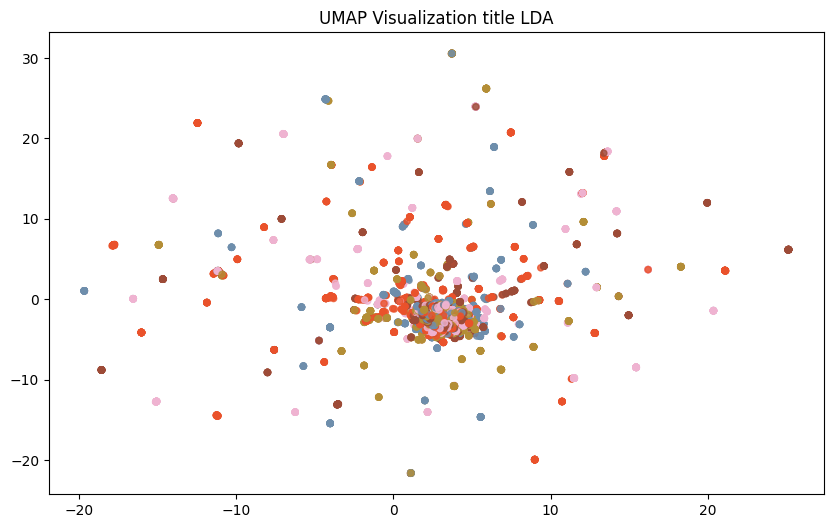

In [35]:
#embedding
umap = UMAP(n_components=2)
emb = umap.fit_transform(tfidf_matrix)

viz = pd.DataFrame({
    'title': titles, 
    'topic': topic_assignments, 
    'X': emb[:,0], 
    'Y': emb[:,1]
})
plt.figure(figsize=(10, 6))
plt.scatter(viz.X, viz.Y, s=20, alpha=0.8, c=viz.topic, cmap=custom_cmap)
plt.title('UMAP Visualization title LDA')
plt.show()

### Use titles and user data for umap

In [36]:
#one hot encode the user data
one_hot_encoded = pd.get_dummies(df[['Z30_CALL_NO', 'Z36H_ID', 'Z13_TITLE', 'sig_lev_1']], columns=['Z36H_ID'])
aggregated = one_hot_encoded.groupby('Z30_CALL_NO').max()

In [37]:
aggregated

,Z13_TITLE,sig_lev_1,Z36H_ID_BHR-100,Z36H_ID_BHR-101,Z36H_ID_BHR-122,Z36H_ID_BHR-135,Z36H_ID_BHR-34,Z36H_ID_BHR-35,Z36H_ID_BHR-36,Z36H_ID_BHR-48,...,Z36H_ID_MPG000013297,Z36H_ID_MPG000013328,Z36H_ID_MPG000013329,Z36H_ID_MPG000013385,Z36H_ID_MPG000013396,Z36H_ID_MPG000013469,Z36H_ID_MPG000013483,Z36H_ID_MPG000013525,Z36H_ID_MPG000013532,Z36H_ID_MPG000013536
Z30_CALL_NO,,,,,,,,,,,,,,,,,,,,,
Aa 234-4850/c1,The dictionary of national biography,A,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Aa 234-4850/c21,The dictionary of national biography,A,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Aa 234-4850/c3,The dictionary of national biography,A,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Aa 234-4850/c4,The dictionary of national biography,A,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Aa 234-4850/c5,The dictionary of national biography,A,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Xy-IST 32-5130 gr,The church of Saint Eirene at Constantinople,X,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Xy-IST 32-5974 gr,Hagia Sophia,X,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Xy-IST 32-5975 gr,Kalenderhane in Istanbul,X,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [38]:
#tf-idf the titles
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), stop_words= 'english')
features = tf.fit_transform(aggregated['Z13_TITLE'])

In [39]:
# Concatenate the TF-IDF and one-hot encoded data horizontally
one_hot_data = aggregated.drop(columns=['Z13_TITLE', 'sig_lev_1']).values
combined_data = np.hstack((features.toarray(), one_hot_data))
sig_lev_1_labels = aggregated['sig_lev_1']

In [41]:
umap = UMAP(n_components=2).fit_transform(combined_data)

# Create a mapping from labels to color indices
label_to_color_index = {label: idx for idx, label in enumerate(np.unique(sig_lev_1_labels))}

# Map labels to color indices
color_indices = np.array([label_to_color_index[label] for label in sig_lev_1_labels])



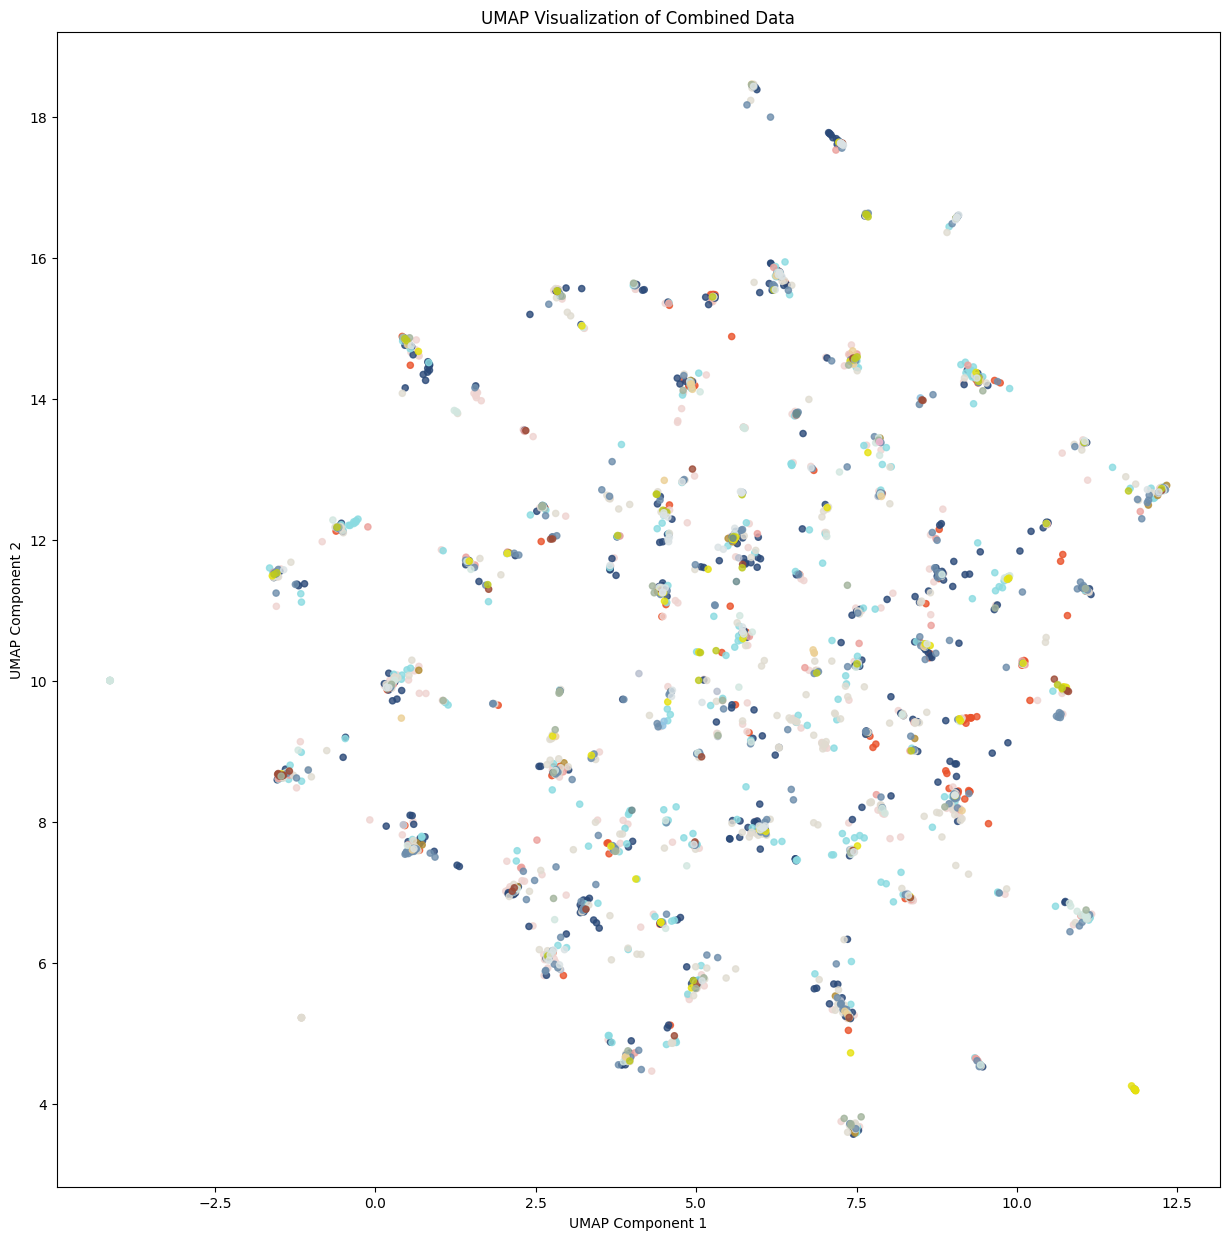

In [42]:
# Create a scatter plot to visualize the reduced-dimensional data
fig, ax = plt.subplots(figsize=(15, 15))

plt.scatter(umap[:, 0], umap[:, 1], s=20, alpha=0.8, c=color_indices, cmap=custom_cmap)
plt.title('UMAP Visualization of Combined Data')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()

## Mapping users using books

In [21]:
#one hot encode the user data
one_hot_encoded = pd.get_dummies(df[['Z30_CALL_NO', 'Z36H_ID']], columns=['Z30_CALL_NO'])
aggregated = one_hot_encoded.groupby('Z36H_ID').max()

In [23]:
umap = UMAP(n_components=2).fit_transform(aggregated.values)

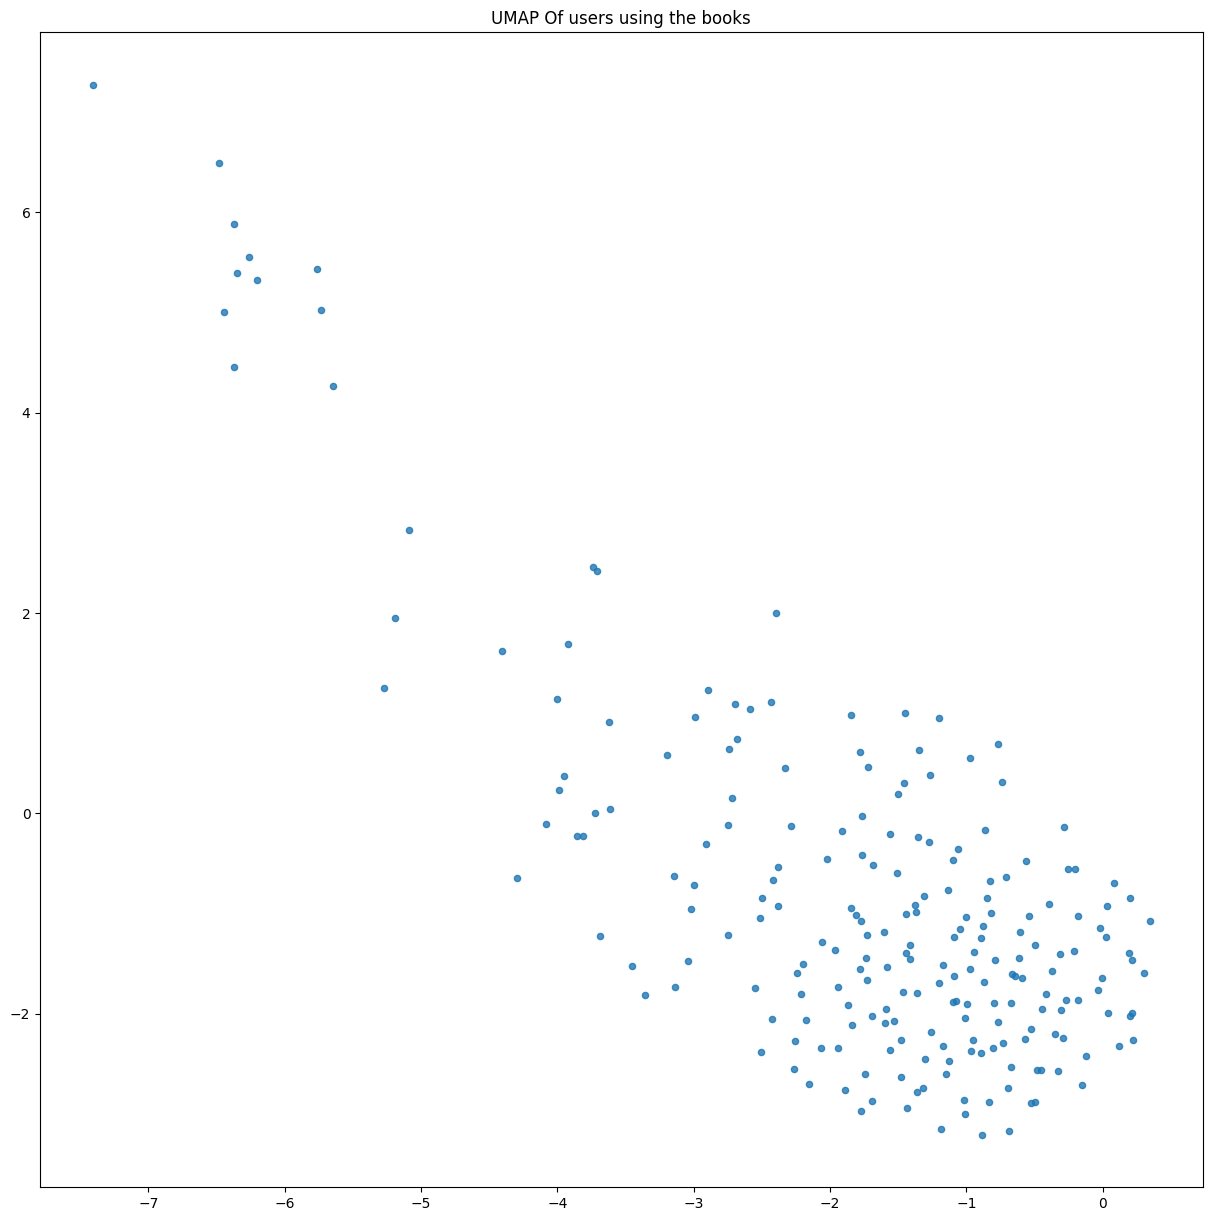

In [26]:
# Create a scatter plot to visualize the reduced-dimensional data
fig, ax = plt.subplots(figsize=(15, 15))

plt.scatter(umap[:, 0], umap[:, 1], s=20, alpha=0.8)
plt.title('UMAP Of users using the books')
plt.show()


### Networkx

I don't this is working well, but it was worth a little exploration

In [12]:
df = eng
G = nx.Graph()

for _, row in df.iterrows():
    user = row['Z36H_ID']
    book = row['Z30_CALL_NO']

    # Add an edge between books if the same user has read both
    books_read_by_user = df[df['Z36H_ID'] == user]['Z30_CALL_NO'].tolist()
    for other_book in books_read_by_user:
        if book != other_book:
            G.add_edge(book, other_book)

print('number of edges: {}'.format(G.number_of_edges()))
print('number of nodes: {}'.format(G.number_of_nodes()))

number of edges: 97116
number of nodes: 2271


/var/folders/fs/xb9k_3m95gq0wjgk1kgw1nxr0000gn/T/ipykernel_1010/86672361.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random_nodes = random.sample(G.nodes, k=min(num_nodes_to_display, len(G.nodes)))


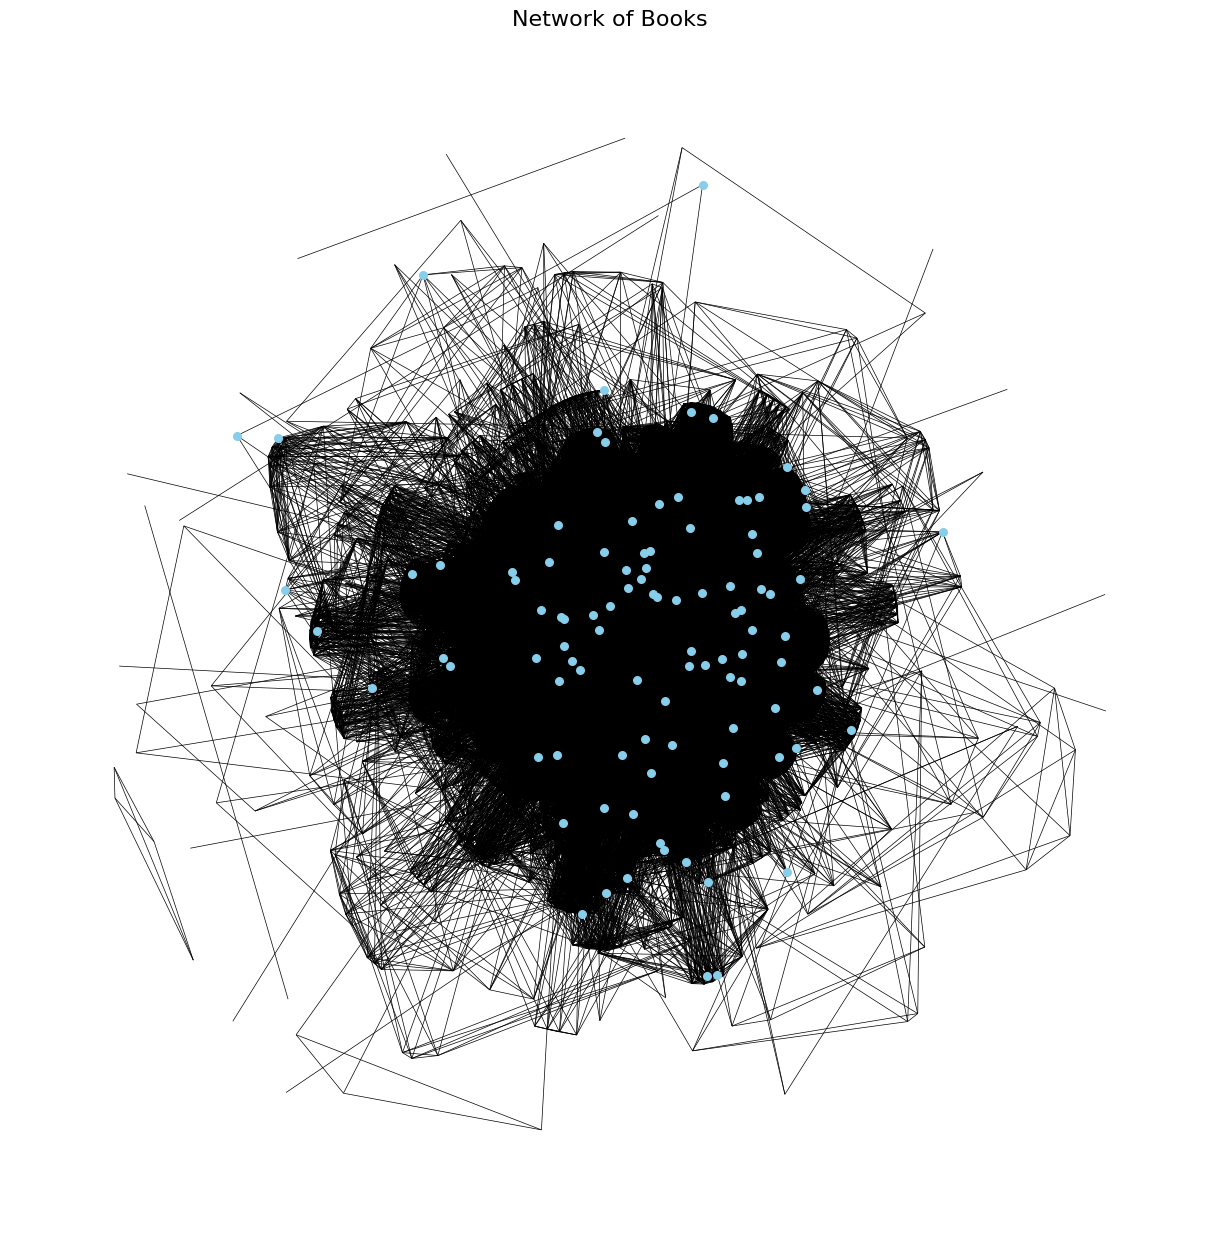

In [13]:
# Reduce the number of nodes for visualization (e.g., take a random subset)
num_nodes_to_display = 100
random_nodes = random.sample(G.nodes, k=min(num_nodes_to_display, len(G.nodes)))

# Customize the layout and appearance
pos = nx.spring_layout(G, seed=42, k=0.25, iterations=50)  # Adjust 'k' and 'iterations' for better dispersion

# Customize node and edge appearance
node_size = 30
edge_width = 0.5

# Visualize the network graph
plt.figure(figsize=(12, 12))  # Adjust the figure size as needed
nx.draw(G, pos, with_labels=False, node_size=node_size, node_color='skyblue', font_color='black', nodelist=random_nodes, width=edge_width)
plt.title("Network of Books", fontsize=16)
plt.axis('off')  # Turn off axis labels
plt.show()